# Introduction to Urban Driver

In this notebook you are going to train the planner introduced in [Urban Driver: Learning to Drive from Real-world Demonstrations Using Policy Gradients](https://openreview.net/pdf?id=ibktAcINCaj).

You will train your model using the Lyft Prediction Dataset and [L5Kit](https://github.com/lyft/l5kit).
**Before starting, please download the [Lyft L5 Prediction Dataset 2020](https://self-driving.lyft.com/level5/prediction/) and follow [the instructions](https://github.com/lyft/l5kit#download-the-datasets) to correctly organise it.**

### Model

From the paper:
```
We use a graph neural network for parametrizing our policy.
It combines a PointNet-like architecture for local inputs processing followed by an attention mechanism for global reasoning. In contrast to VectorNet, we use points instead of vectors. Given the set of points corresponding to each input element, we employ 3 PointNet layers to calculate a 128-dimensional feature descriptor. Subsequently, a single layer of scaled dot-product attention performs global feature aggregation, yielding the predicted trajectory. [...] In total, our model contains around 3.5 million trainable parameters, and training takes 30h on 32 Tesla V100 GPUs. For more details we refer to Appendix C.
```
We also report a diagram of the full model:

![model](../../docs/images/urban_driver/model.svg)


#### Inputs
Urban Driver is based on a vectorized representation of the world. From the paper:
```
We define the state as the whole set of static and dynamic elements the model receive as input. Each element is composed of a variable number of points, which can represent both time (e.g. for agents) and space (e.g. for lanes). The number of features per point depends on the element type. We pad all features to a fixed size F to ensure they can share the first fully connected layer. We include all elements up to the listed maximal number in a circular FOV of radius 35m around the SDV. Note that for performance and simplicity we only execute this query once, and then unroll within this world state.
```

In more details:


| State element(s) | Elements per state | Points per element | Point features description                                                               |
|------------------|--------------------|--------------------|------------------------------------------------------------------------------------------|
| SDV              | 1                  | 4                  | SDV's X, Y and yaw pose of the current time step, as well as previous timesteps          |
| Agents           | up to 30           | 4                  | other agents' X, Y and yaw poses of the current time step, as well as previous timesteps |
| Lanes mid        | up to 30           | 20                 | interpolated X, Y points of the lanes' center lines, with optional traffic light signals |
| Lanes left       | up to 30           | 20                 | interpolated X, Y points of the left lane boundaries                                     |
| Lanes right      | up to 30           | 20                 | interpolated X, Y points of the right lane boundaries                                    |
| Crosswalks       | up to 20           | up to 20           | crosswalks' polygon boundaries - X, Y                                                    |



#### Outputs
Urban Driver outputs the next positions and orientations of the SDV. Each timestep is a tuple consisting of `(X, Y, yaw)`.

### Training in closed loop
One of the main features of Urban Driver is how it is trained; from the paper:
```
[...] we then train a policy network in closed-loop employing policy gradients.
We train our proposed method on 100 hours of expert demonstrations on urban roads and show that it learns complex driving policies that generalize well and can perform a variety of driving maneuvers
```

When training in closed-loop, the model does not predict all timesteps at once, but instead predicts one action at a time and use that action to perform a step in the surrounding environment before repeating the process. This allows the model to capture how the environment evolves as it takes decisions.

Compare Figure 3 from the original paper:

![model](../../docs/images/urban_driver/method.png)

```
One iteration of policy gradient update. Given a real-world expert trajectory we sample a policy state by unrolling the policy for T steps. We then compute optimal policy update by backpropagation through time.
```


Closed-loop training has two major advantages:
- reducing the domain shift between training and evaluation;
- replacing hand-crafted off-policy perturbations with on-policy perturbations generated by the model itself

Again from the paper:
```
[...] reports performance when all methods are trained to optimize the imitation loss alone. Behavioral cloning yields a high number of trajectory errors and collisions. This is expected, as this approach is known to suffer from the issue of covariate shift 
```

In [1]:
import os

from matplotlib import pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from tqdm import tqdm
from tempfile import gettempdir

from l5kit.configs import load_config_data
from l5kit.data import ChunkedDataset, LocalDataManager
from l5kit.dataset import EgoDatasetVectorized
from l5kit.planning.vectorized.closed_loop_model import VectorizedUnrollModel
from l5kit.planning.vectorized.open_loop_model import VectorizedModel
from l5kit.vectorization.vectorizer_builder import build_vectorizer

## Prepare data path and load cfg

By setting the `L5KIT_DATA_FOLDER` variable, we can point the script to the folder where the data lies.

Then, we load our config file with relative paths and other configurations (rasteriser, training params...).

In [2]:
#@title Download L5 Sample Dataset and install L5Kit
import os
RunningInCOLAB = 'google.colab' in str(get_ipython())
if RunningInCOLAB:
    !wget https://raw.githubusercontent.com/lyft/l5kit/master/examples/setup_notebook_colab.sh -q
    !sh ./setup_notebook_colab.sh
    os.environ["L5KIT_DATA_FOLDER"] = open("./dataset_dir.txt", "r").read().strip()
else:
    print("Not running in Google Colab.")
    os.environ["L5KIT_DATA_FOLDER"] = "../simulation/"

Not running in Google Colab.


In [3]:
dm = LocalDataManager(None)
# get config
cfg = load_config_data("./config.yaml")

In [4]:
# ===== INIT DATASET
train_zarr = ChunkedDataset(dm.require(cfg["train_data_loader"]["key"])).open()

vectorizer = build_vectorizer(cfg, dm)
train_dataset = EgoDatasetVectorized(cfg, train_zarr, vectorizer)
print(train_dataset)

+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
| Num Scenes | Num Frames | Num Agents | Num TR lights | Total Time (hr) | Avg Frames per Scene | Avg Agents per Frame | Avg Scene Time (sec) | Avg Frame frequency |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+
|   16265    |  4039527   | 320124624  |    38735988   |      112.19     |        248.36        |        79.25         |        24.83         |        10.00        |
+------------+------------+------------+---------------+-----------------+----------------------+----------------------+----------------------+---------------------+


In [6]:
cfg["train_data_loader"]["key"]

'scenes/train.zarr'

# Choosing the model

You can use this notebook to train not only Urban Driver, but also several ablations included in the paper. We provide the following options:
- Urban Driver: this is the default value and the model presented in the paper;
- Urban Driver without BPTT: this is an ablation of Urban Driver where we detach the gradient between steps;
- Open Loop Planner: this is vectorized model trained with simple behavioural cloning;

We now detail which config changes are necessary to obtain the baseline models - note that these are also required when loading pre-trained models for evaluation:

| Model     | Changes to config |
| ----------- | ----------- |
| Open Loop Planner  (BC-perturb)   | - history_num_frames_ego: 0 |
| Open Loop Planner with Ego History  (BC-perturb) | None  |
| Urban Driver without BPTT (MS Prediction)   | - future_num_frames: 32 <br/> - warmup_num_frames: 20|
| Urban Driver without BPTT (Ours)   | - future_num_frames: 32 <br/> - warmup_num_frames: 20 <br/> - detach_unroll: False|

In [7]:
URBAN_DRIVER = "Urban Driver"
OPEN_LOOP_PLANNER = "Open Loop Planner"

In [9]:
model_name = URBAN_DRIVER

weights_scaling = [1.0, 1.0, 1.0]

_num_predicted_frames = cfg["model_params"]["future_num_frames"]
_num_predicted_params = len(weights_scaling)


if model_name == URBAN_DRIVER:
    model = VectorizedUnrollModel(
        history_num_frames_ego=cfg["model_params"]["history_num_frames_ego"],
        history_num_frames_agents=cfg["model_params"]["history_num_frames_agents"],
        num_targets=_num_predicted_params * _num_predicted_frames,
        weights_scaling=weights_scaling,
        criterion=nn.L1Loss(reduction="none"),
        global_head_dropout=cfg["model_params"]["global_head_dropout"],
        disable_other_agents=cfg["model_params"]["disable_other_agents"],
        disable_map=cfg["model_params"]["disable_map"],
        disable_lane_boundaries=cfg["model_params"]["disable_lane_boundaries"],
        detach_unroll=cfg["model_params"]["detach_unroll"],
        warmup_num_frames=cfg["model_params"]["warmup_num_frames"],
        discount_factor=cfg["model_params"]["discount_factor"],
    )

elif model_name == OPEN_LOOP_PLANNER:
    model = VectorizedModel(
        history_num_frames_ego=cfg["model_params"]["history_num_frames_ego"],
        history_num_frames_agents=cfg["model_params"]["history_num_frames_agents"],
        num_targets=_num_predicted_params * _num_predicted_frames,
        weights_scaling=weights_scaling,
        criterion=nn.L1Loss(reduction="none"),
        global_head_dropout=cfg["model_params"]["global_head_dropout"],
        disable_other_agents=cfg["model_params"]["disable_other_agents"],
        disable_map=cfg["model_params"]["disable_map"],
        disable_lane_boundaries=cfg["model_params"]["disable_lane_boundaries"],
    )
else:
    raise ValueError(f"{model_name} is invalid")

# Prepare for training
Our `EgoDatasetVectorized` inherits from PyTorch `Dataset`; so we can use it inside a `Dataloader` to enable multi-processing.

In [10]:
train_cfg = cfg["train_data_loader"]
train_dataloader = DataLoader(train_dataset, shuffle=train_cfg["shuffle"], batch_size=train_cfg["batch_size"],
                              num_workers=train_cfg["num_workers"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [16]:
train_dataset[0].keys()

dict_keys(['extent', 'type', 'agent_from_world', 'world_from_agent', 'target_positions', 'target_yaws', 'target_extents', 'target_availabilities', 'history_positions', 'history_yaws', 'history_extents', 'history_availabilities', 'centroid', 'yaw', 'speed', 'all_other_agents_history_positions', 'all_other_agents_history_yaws', 'all_other_agents_history_extents', 'all_other_agents_history_availability', 'all_other_agents_future_positions', 'all_other_agents_future_yaws', 'all_other_agents_future_extents', 'all_other_agents_future_availability', 'all_other_agents_types', 'agent_trajectory_polyline', 'agent_polyline_availability', 'other_agents_polyline', 'other_agents_polyline_availability', 'lanes', 'lanes_availabilities', 'lanes_mid', 'lanes_mid_availabilities', 'crosswalks', 'crosswalks_availabilities', 'scene_index', 'host_id', 'timestamp', 'track_id'])

# Training loop
Here, we purposely include a barebone training loop. Clearly, many more components can be added to enrich logging and improve performance. Still, the sheer size of our dataset ensures that a reasonable performance can be obtained even with this simple loop.

In [11]:
tr_it = iter(train_dataloader)
progress_bar = tqdm(range(cfg["train_params"]["max_num_steps"]))
losses_train = []
model.train()
torch.set_grad_enabled(True)

for _ in progress_bar:
    try:
        data = next(tr_it)
    except StopIteration:
        tr_it = iter(train_dataloader)
        data = next(tr_it)
    # Forward pass
    data = {k: v.to(device) for k, v in data.items()}
    result = model(data)
    loss = result["loss"]
    # Backward pass
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses_train.append(loss.item())
    progress_bar.set_description(f"loss: {loss.item()} loss(avg): {np.mean(losses_train)}")

loss: 21.20723533630371 loss(avg): 21.60830674171448: 100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


### Plot the train loss curve
We can plot the train loss against the iterations (batch-wise) to check if our model has converged.

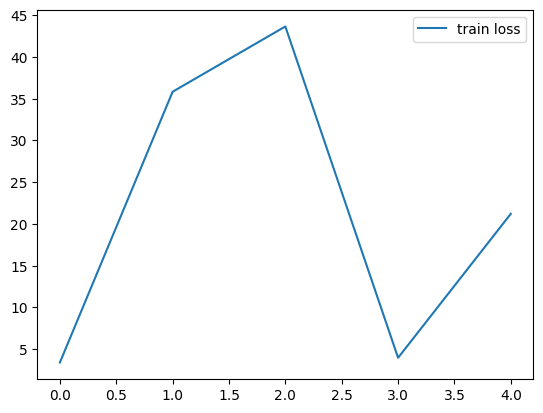

In [12]:
plt.plot(np.arange(len(losses_train)), losses_train, label="train loss")
plt.legend()
plt.show()

# Store the model

Let's store the model as a torchscript. This format allows us to re-load the model and weights without requiring the class definition later.

**Take note of the path, you will use it later to evaluate your planning model!**

In [13]:
to_save = torch.jit.script(model.cpu())
path_to_save = f"{gettempdir()}/urban_driver.pt"
to_save.save(path_to_save)
print(f"MODEL STORED at {path_to_save}")

MODEL STORED at /tmp/urban_driver.pt


# Congratulations in training your very own Urban Driver model!
### What's Next

Now that your model is trained and safely stored, you can evaluate how it performs in our simulation:


### [Closed-loop evaluation](./closed_loop_test.ipynb)
In this setting the model **is in full control of the AV's** future movements.

## Pre-trained models
We provide a collection of pre-trained models, including both our proposed method and several ablations from our paper:
- [Urban Driver](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/urban_driver/BPTT.pt);
- [Urban Driver without BPTT](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/urban_driver/MS.pt);
- [Open Loop](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/urban_driver/OL.pt);
- [Open Loop with history](https://lyft-l5-datasets-public.s3-us-west-2.amazonaws.com/models/urban_driver/OL_HS.pt);

To use one of the models simply download the corresponding `.pt` file and load it in the evaluation notebooks - further, please see the comments above regarding necessary config changes.